# OLA - Ensemble

## Problem Statement
- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
1. Demographics (city, age, gender etc.)
2. Tenure information (joining date, Last Date)
3. Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [3]:
# import the data in notebook
df=pd.read_csv('ola_driver.csv')

# Exploratory Data Analysis

In [4]:
# obwerving first 5 rows of the data
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
# dropping unnamed column
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [6]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [7]:
df.shape

(19104, 13)

In [8]:
# information about the columns and its datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


### Column Profiling:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [9]:
df.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


#### Insights
- There is significant difference in mean and median in Income and Total business Value Data.
- So outliers are present and needs to be handled

In [10]:
# no of unique drivers in dataset
len(df['Driver_ID'].unique())

2381

In [11]:
df[df['Driver_ID']==26]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
138,01/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,243110,4
139,02/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,646330,4
140,03/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,17651940,4
141,04/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,242510,4
142,05/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,1098080,4
143,06/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,1212720,4
144,07/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,2695910,4
145,08/01/19,26,41.0,0.0,C14,2,121529,05/07/18,NaN,1,3,494710,4
146,09/01/19,26,42.0,0.0,C14,2,121529,05/07/18,NaN,1,3,986540,4
147,10/01/19,26,42.0,0.0,C14,2,121529,05/07/18,NaN,1,3,9950710,4


#### Insights
- Data shows that for each driver ID monthly data is provided

### Univariate analysis

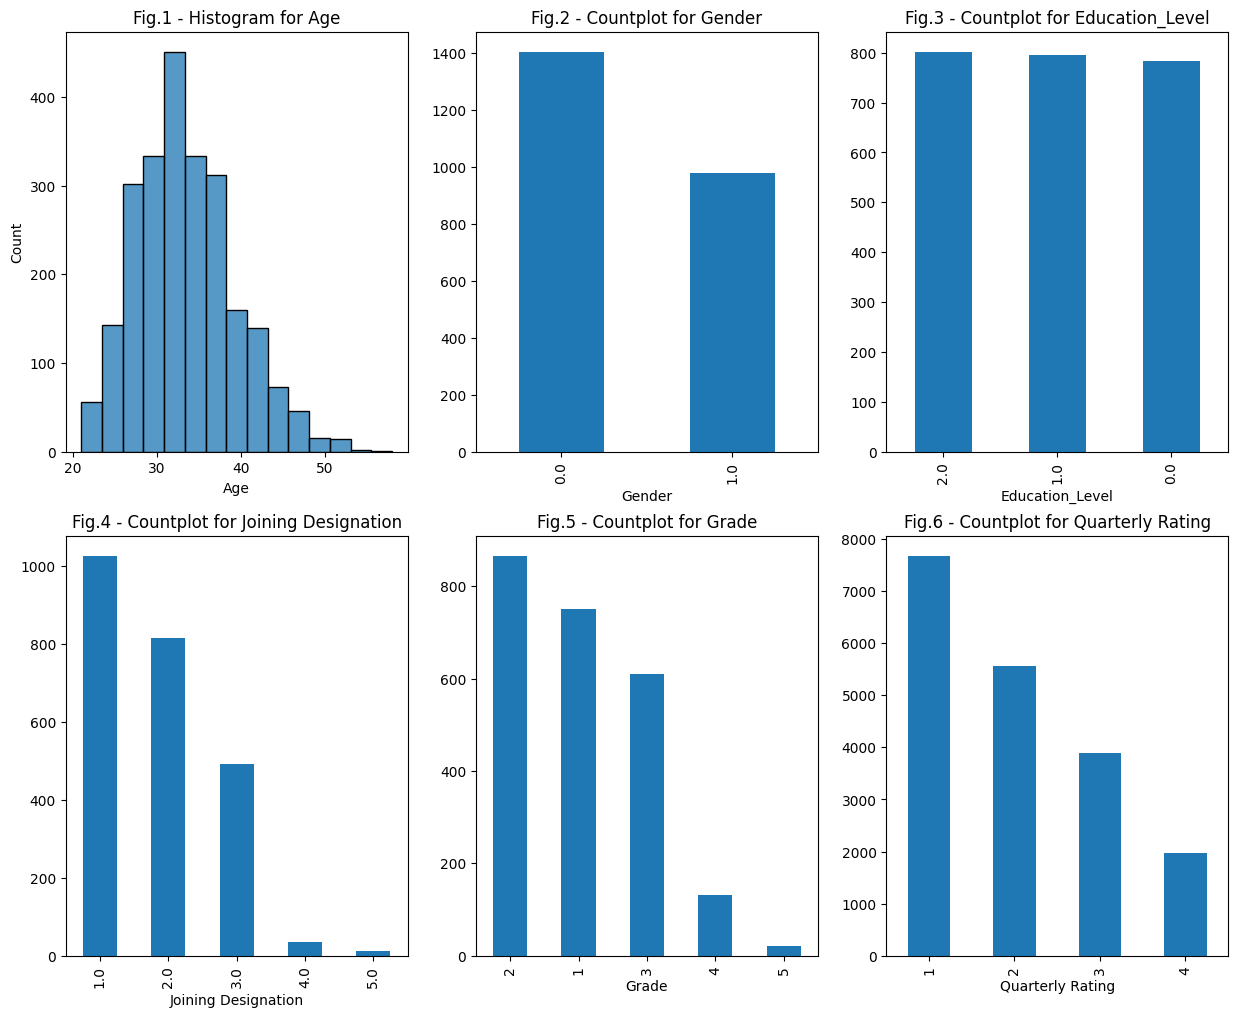

In [12]:
plt.figure(figsize=(15,12))

plt.subplot(2,3,1)
sns.histplot(df.groupby('Driver_ID')['Age'].mean(),bins=15)
plt.title('Fig.1 - Histogram for Age')

plt.subplot(2,3,2)
df.groupby('Driver_ID')['Gender'].mean().value_counts().plot(kind='bar')
plt.title('Fig.2 - Countplot for Gender')

plt.subplot(2,3,3)
df.groupby('Driver_ID')['Education_Level'].mean().value_counts().plot(kind='bar')
plt.title('Fig.3 - Countplot for Education_Level')

plt.subplot(2,3,4)
df.groupby('Driver_ID')['Joining Designation'].mean().value_counts().plot(kind='bar')
plt.title('Fig.4 - Countplot for Joining Designation')

plt.subplot(2,3,5)
df.groupby('Driver_ID')['Grade'].min().value_counts().plot(kind='bar')
plt.title('Fig.5 - Countplot for Grade')

plt.subplot(2,3,6)
df['Quarterly Rating'].value_counts().plot(kind='bar')
plt.title('Fig.6 - Countplot for Quarterly Rating')

plt.show()

#### Insights:
-  Driver age is normally distributed between 20 to 60
-  There are more male than female drives
-  There is more driver having education 12+
-  Most of the driver join at designation level 1
-  Most drive have the grade 2 at joining
-  Qeality rating 1 is recieved the most

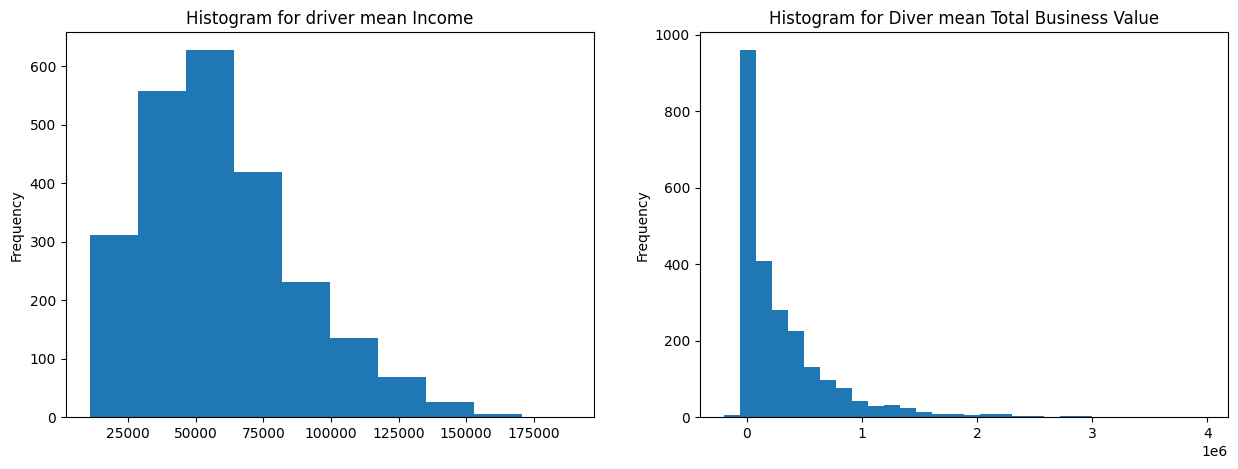

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
df.groupby('Driver_ID')['Income'].mean().plot(kind='hist')
plt.title('Histogram for driver mean Income')

plt.subplot(1,2,2)
df.groupby('Driver_ID')['Total Business Value'].mean().sort_values().plot(kind='hist',bins=30)
plt.title('Histogram for Diver mean Total Business Value')

plt.show()

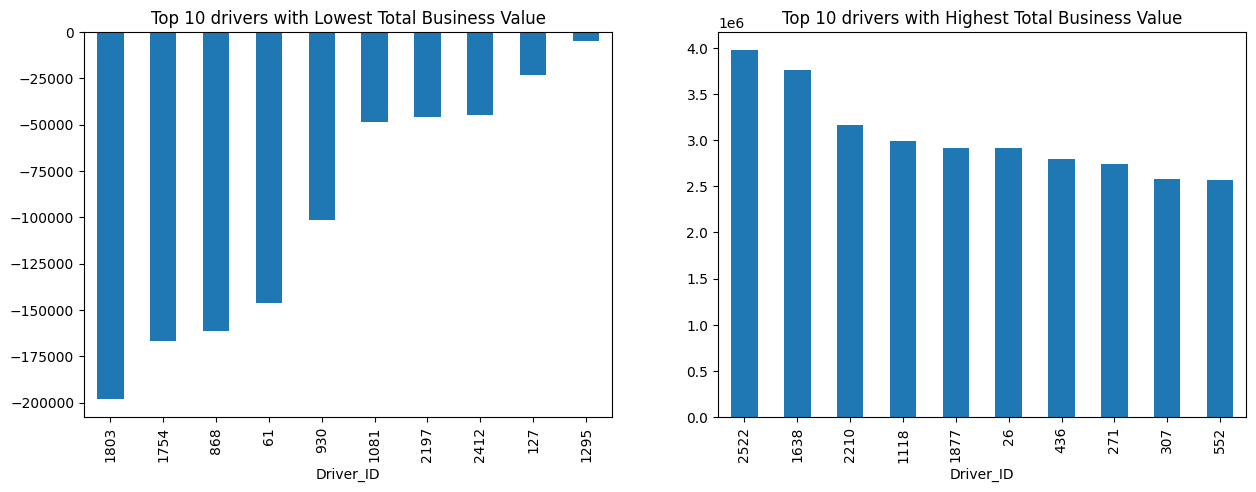

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
df.groupby('Driver_ID')['Total Business Value'].mean().sort_values()[:10].plot(kind='bar')
plt.title('Top 10 drivers with Lowest Total Business Value')

plt.subplot(1,2,2)
df.groupby('Driver_ID')['Total Business Value'].mean().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 drivers with Highest Total Business Value')

plt.show()

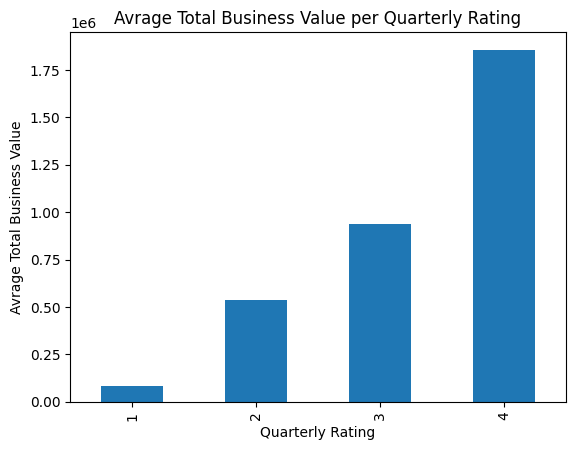

In [15]:
df.groupby('Quarterly Rating')['Total Business Value'].mean().plot(kind='bar')
plt.title('Avrage Total Business Value per Quarterly Rating')
plt.ylabel('Avrage Total Business Value')
plt.show()

#### Insights
- Mean driver income ranges between 50000-75000

### Bivariate analysis

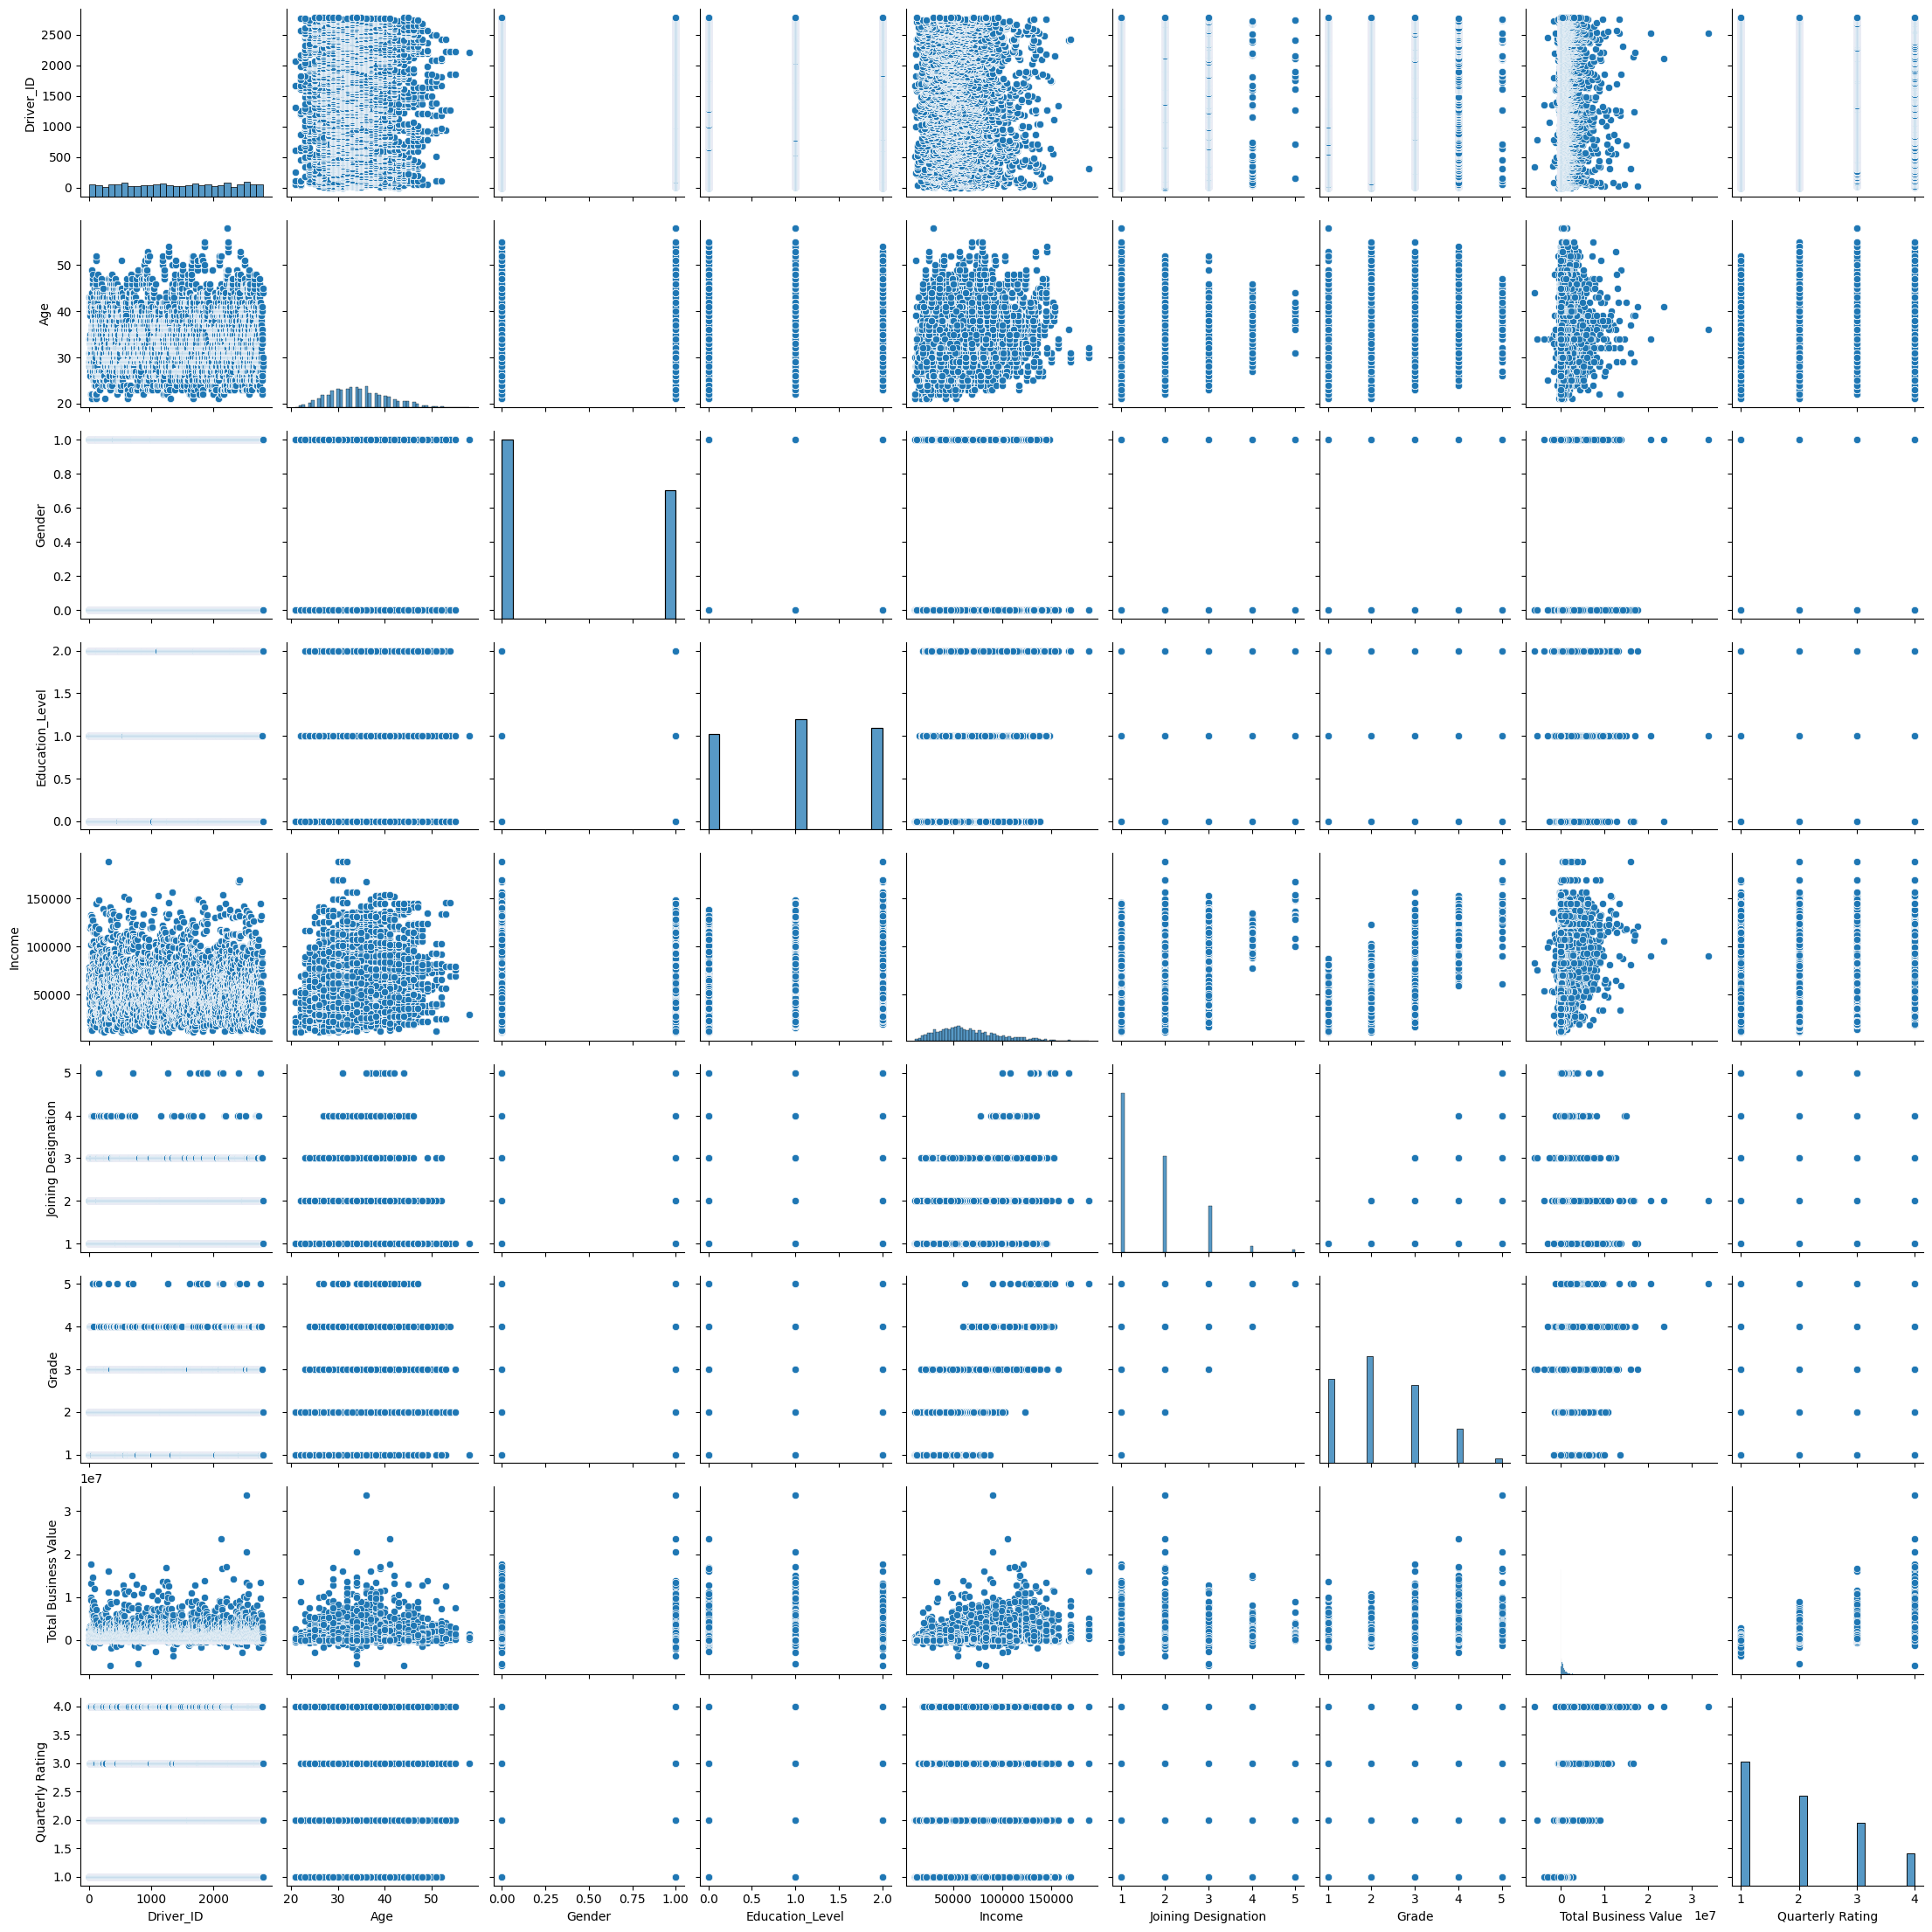

In [19]:
sns.pairplot(data=df)
plt.show()

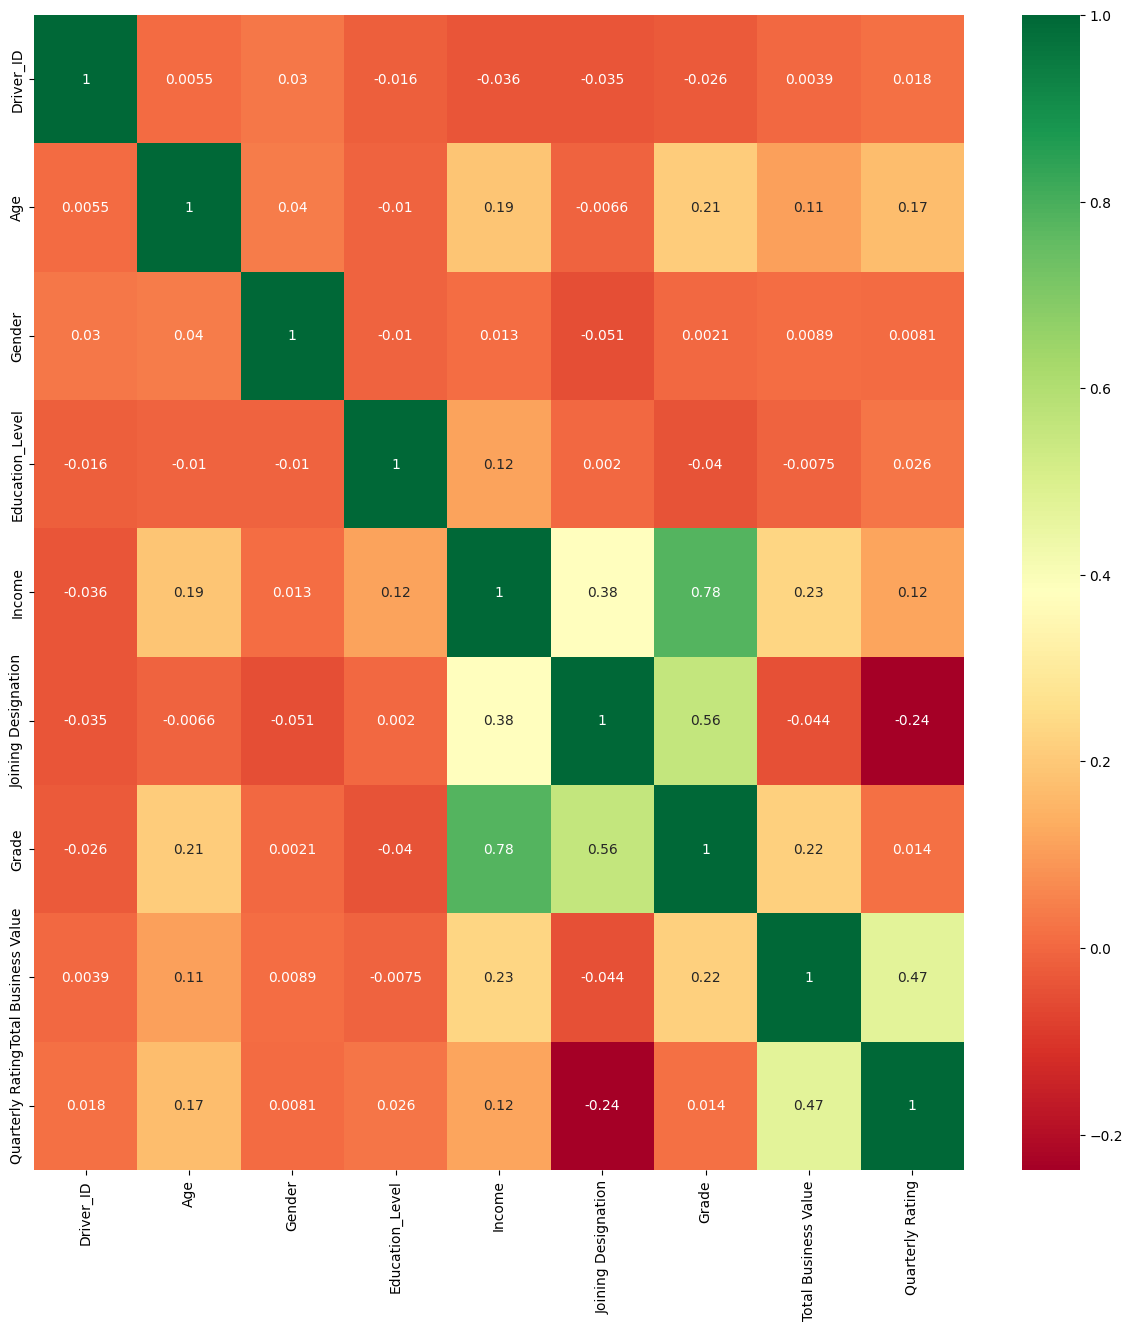

In [25]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="RdYlGn", annot_kws={"size":10})
plt.show()

#### Insights:
- We can say that the High Quality rating able to generate High Business value
- Income and grade has high correlation
- Quaterly ratinbg helps to acieve higher total business value

# Data Preprocessing

## Feature Engineering

In [26]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [28]:
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],format= '%d/%m/%y')
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'],format= '%d/%m/%y')
df['MMM-YY']=pd.to_datetime(df['MMM-YY'],format= '%d/%m/%y')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [30]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-01-02,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-01-03,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2
3,2020-01-11,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1
4,2020-01-12,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1


In [31]:
df['churn'] = df['LastWorkingDate'].notnull()

In [32]:
df['churn'] = df['churn'].astype(int)

In [33]:
df.drop('LastWorkingDate', axis=1, inplace=True)

In [34]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,2381060,2,0
1,2019-01-02,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,-665480,2,0
2,2019-01-03,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,0,2,1
3,2020-01-11,2,31.0,0.0,C7,2,67016,2020-06-11,2,2,0,1,0
4,2020-01-12,2,31.0,0.0,C7,2,67016,2020-06-11,2,2,0,1,0


In [35]:
# active users
df.groupby('Driver_ID')['churn'].max().value_counts()

churn
1    1616
0     765
Name: count, dtype: int64

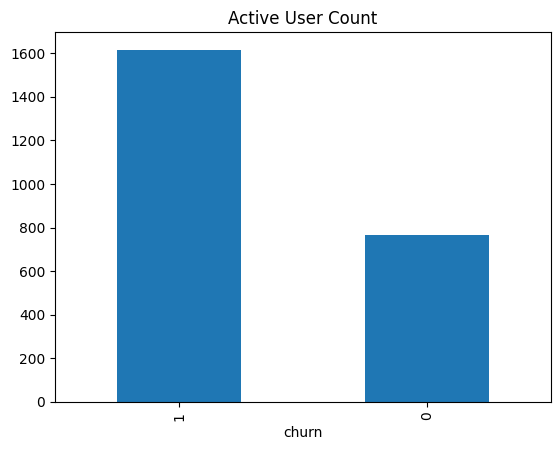

In [36]:
# active users
plt.title('Active User Count')
df.groupby('Driver_ID')['churn'].max().value_counts().plot(kind='bar')
plt.show()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   Joining Designation   19104 non-null  int64         
 9   Grade                 19104 non-null  int64         
 10  Total Business Value  19104 non-null  int64         
 11  Quarterly Rating      19104 non-null  int64         
 12  churn                 19104 non-null  int32         
dtypes: datetime64[ns

### missing value detection

In [38]:
#checking Missing values
df.isna().sum()

MMM-YY                   0
Driver_ID                0
Age                     61
Gender                  52
City                     0
Education_Level          0
Income                   0
Dateofjoining            0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
churn                    0
dtype: int64

In [39]:
df.isna().sum()/len(df)*100

MMM-YY                  0.000000
Driver_ID               0.000000
Age                     0.319305
Gender                  0.272194
City                    0.000000
Education_Level         0.000000
Income                  0.000000
Dateofjoining           0.000000
Joining Designation     0.000000
Grade                   0.000000
Total Business Value    0.000000
Quarterly Rating        0.000000
churn                   0.000000
dtype: float64

#### Insight:
- Very low missing values are present in dataset
- Can be handles with KNN imputation

## Outlier detection and handling

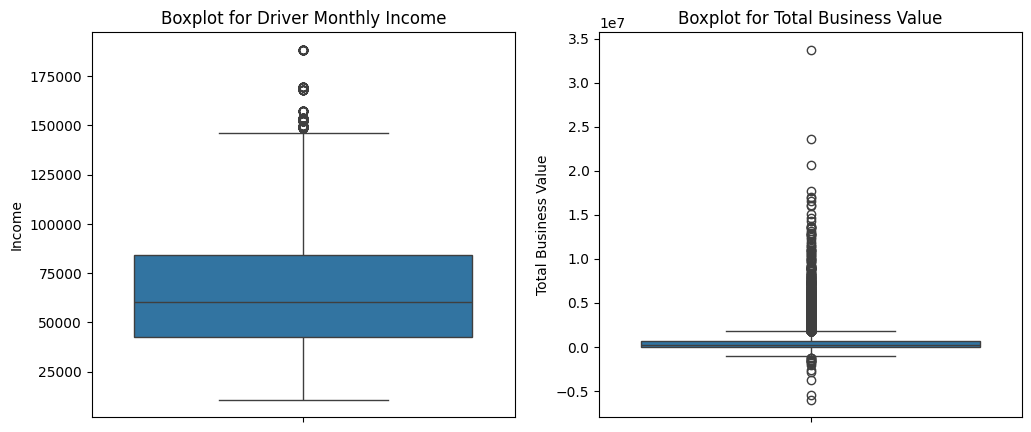

In [40]:
# Finding Outliers
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(data=df['Income'],whis=1.5)
plt.title('Boxplot for Driver Monthly Income')

plt.subplot(1,2,2)
sns.boxplot(data=df['Total Business Value'])
plt.title('Boxplot for Total Business Value')

plt.show()

In [41]:
percentiles = df['Income'].quantile([0,0.99]).values
df['Income']=np.clip(df['Income'], percentiles[0], percentiles[1])

In [42]:
percentiles = df['Total Business Value'].quantile([0.005,0.929]).values
df['Total Business Value']=np.clip(df['Total Business Value'], percentiles[0], percentiles[1])

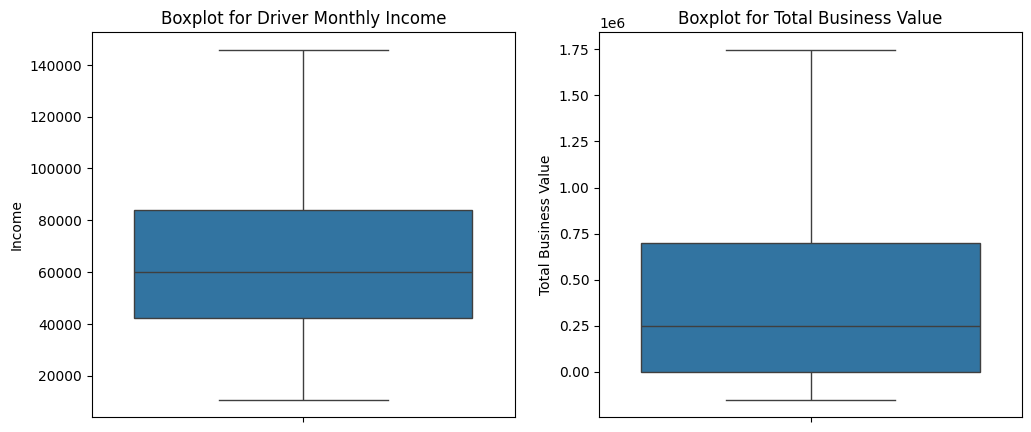

In [43]:
# Finding Outliers
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(data=df['Income'])
plt.title('Boxplot for Driver Monthly Income')

plt.subplot(1,2,2)
sns.boxplot(data=df['Total Business Value'])
plt.title('Boxplot for Total Business Value')

#plt.subplot(1,3,3)
#sns.boxplot(data=df.groupby('Driver_ID')['Total Business Value'].mean())
#plt.title('Boxplot for Driver Average Total Business Value')

plt.show()

In [44]:
x=df[['Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating', 'churn']]

## Encoding

- Using target encoding to code the city
- To identify the level of city, City is encoded using Income as target veriable

In [45]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
df['city_encode'] = encoder.fit_transform(df['City'], df['Income'])

In [46]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn,city_encode
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,1748377.93,2,0,61722.271375
1,2019-01-02,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,-151061.90,2,0,61722.271375
2,2019-01-03,1,28.0,0.0,C23,2,57387,2018-12-24,1,1,0.00,2,1,61722.271375
3,2020-01-11,2,31.0,0.0,C7,2,67016,2020-06-11,2,2,0.00,1,0,66427.244663
4,2020-01-12,2,31.0,0.0,C7,2,67016,2020-06-11,2,2,0.00,1,0,66427.244663


In [47]:
df.drop(['City'],axis=1,inplace= True)

In [48]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,Education_Level,Income,Dateofjoining,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn,city_encode
0,2019-01-01,1,28.0,0.0,2,57387,2018-12-24,1,1,1748377.93,2,0,61722.271375
1,2019-01-02,1,28.0,0.0,2,57387,2018-12-24,1,1,-151061.90,2,0,61722.271375
2,2019-01-03,1,28.0,0.0,2,57387,2018-12-24,1,1,0.00,2,1,61722.271375
3,2020-01-11,2,31.0,0.0,2,67016,2020-06-11,2,2,0.00,1,0,66427.244663
4,2020-01-12,2,31.0,0.0,2,67016,2020-06-11,2,2,0.00,1,0,66427.244663


## KNNImputer

In [49]:
x=np.array(df[['Age', 'Gender', 'city_encode', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating', 'churn']])

In [50]:
imputer = KNNImputer(n_neighbors=5)

In [51]:
df[['Age', 'Gender', 'city_encode', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating', 'churn']]=imputer.fit_transform(x)

In [52]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,Education_Level,Income,Dateofjoining,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn,city_encode
0,2019-01-01,1,28.0,0.0,2.0,57387.0,2018-12-24,1.0,1.0,1748377.93,2.0,0.0,61722.271375
1,2019-01-02,1,28.0,0.0,2.0,57387.0,2018-12-24,1.0,1.0,-151061.90,2.0,0.0,61722.271375
2,2019-01-03,1,28.0,0.0,2.0,57387.0,2018-12-24,1.0,1.0,0.00,2.0,1.0,61722.271375
3,2020-01-11,2,31.0,0.0,2.0,67016.0,2020-06-11,2.0,2.0,0.00,1.0,0.0,66427.244663
4,2020-01-12,2,31.0,0.0,2.0,67016.0,2020-06-11,2.0,2.0,0.00,1.0,0.0,66427.244663


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19104 non-null  float64       
 3   Gender                19104 non-null  float64       
 4   Education_Level       19104 non-null  float64       
 5   Income                19104 non-null  float64       
 6   Dateofjoining         19104 non-null  datetime64[ns]
 7   Joining Designation   19104 non-null  float64       
 8   Grade                 19104 non-null  float64       
 9   Total Business Value  19104 non-null  float64       
 10  Quarterly Rating      19104 non-null  float64       
 11  churn                 19104 non-null  float64       
 12  city_encode           19104 non-null  float64       
dtypes: datetime64[ns

In [54]:
df.isna().sum()

MMM-YY                  0
Driver_ID               0
Age                     0
Gender                  0
Education_Level         0
Income                  0
Dateofjoining           0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
churn                   0
city_encode             0
dtype: int64

In [55]:
function_dict = {'Age':'max', 'Gender':'first','city_encode':'first',
                 'Education_Level':'last', 'Income':'last', 
                 'Joining Designation':'last','Grade':'last', 
                 'Dateofjoining':'last','churn':'last',
                 'Total Business Value':'sum','Quarterly Rating':'last'}
new_df=df.groupby(['Driver_ID','MMM-YY']).aggregate(function_dict)

In [56]:
new_df.head()

Age  Gender   city_encode  Education_Level   Income  \
Driver_ID MMM-YY                                                             
1         2019-01-01  28.0     0.0  61722.271375              2.0  57387.0   
          2019-01-02  28.0     0.0  61722.271375              2.0  57387.0   
          2019-01-03  28.0     0.0  61722.271375              2.0  57387.0   
2         2020-01-11  31.0     0.0  66427.244663              2.0  67016.0   
          2020-01-12  31.0     0.0  66427.244663              2.0  67016.0   

                      Joining Designation  Grade Dateofjoining  churn  \
Driver_ID MMM-YY                                                        
1         2019-01-01                  1.0    1.0    2018-12-24    0.0   
          2019-01-02                  1.0    1.0    2018-12-24    0.0   
          2019-01-03                  1.0    1.0    2018-12-24    1.0   
2         2020-01-11                  2.0    2.0    2020-06-11    0.0   
          2020-01-12                  2.0    2.0    2020-06-11    0.0   

                      Total Business Value  Quarterly Rating  
Driver_ID MMM-YY                                              
1         2019-01-01            1748377.93               2.0  
          2019-01-02            -151061.90               2.0  
          2019-01-03                  0.00               2.0  
2         2020-01-11                  0.00               1.0  
          2020-01-12                  0.00               1.0

In [57]:
new_df=new_df.sort_index( ascending=[True,True])

In [58]:
new_df.head()

Age  Gender   city_encode  Education_Level   Income  \
Driver_ID MMM-YY                                                             
1         2019-01-01  28.0     0.0  61722.271375              2.0  57387.0   
          2019-01-02  28.0     0.0  61722.271375              2.0  57387.0   
          2019-01-03  28.0     0.0  61722.271375              2.0  57387.0   
2         2020-01-11  31.0     0.0  66427.244663              2.0  67016.0   
          2020-01-12  31.0     0.0  66427.244663              2.0  67016.0   

                      Joining Designation  Grade Dateofjoining  churn  \
Driver_ID MMM-YY                                                        
1         2019-01-01                  1.0    1.0    2018-12-24    0.0   
          2019-01-02                  1.0    1.0    2018-12-24    0.0   
          2019-01-03                  1.0    1.0    2018-12-24    1.0   
2         2020-01-11                  2.0    2.0    2020-06-11    0.0   
          2020-01-12                  2.0    2.0    2020-06-11    0.0   

                      Total Business Value  Quarterly Rating  
Driver_ID MMM-YY                                              
1         2019-01-01            1748377.93               2.0  
          2019-01-02            -151061.90               2.0  
          2019-01-03                  0.00               2.0  
2         2020-01-11                  0.00               1.0  
          2020-01-12                  0.00               1.0

In [59]:
df1=pd.DataFrame()

In [60]:
df1['Driver_ID']=df['Driver_ID'].unique()

# Aggregation at Driver Level

In [61]:
df1['MMM-YY'] = list(new_df.groupby('Driver_ID',axis=0).agg({'Age':len})['Age'])
df1['Age'] = list(new_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
df1['Gender'] = list(new_df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
df1['city_encode'] = list(new_df.groupby('Driver_ID').agg({'city_encode':'last'})['city_encode'])
df1['Education'] = list(new_df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
df1['Income'] = list(new_df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
df1['Joining_Designation'] = list(new_df.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
df1['Grade'] = list(new_df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
df1['Total_Business_Value'] = list(new_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
df1['Last_Quarterly_Rating'] = list(new_df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])
df1['churn']=list(new_df.groupby('Driver_ID').agg({'churn':'last'})['churn'])

C:\Users\pritamkudale\AppData\Local\Temp\ipykernel_18268\1892426676.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df1['MMM-YY'] = list(new_df.groupby('Driver_ID',axis=0).agg({'Age':len})['Age'])
C:\Users\pritamkudale\AppData\Local\Temp\ipykernel_18268\1892426676.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df1['Age'] = list(new_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
C:\Users\pritamkudale\AppData\Local\Temp\ipykernel_18268\1892426676.py:9: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df1['Total_Business_Value'] = list(new_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])


In [62]:
df1.head()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn
0,1,3,28.0,0.0,61722.271375,2.0,57387.0,1.0,1.0,1597316.03,2.0,1.0
1,2,2,31.0,0.0,66427.244663,2.0,67016.0,2.0,2.0,0.00,1.0,0.0
2,4,5,43.0,0.0,62173.028120,2.0,65603.0,2.0,2.0,350000.00,1.0,1.0
3,5,3,29.0,0.0,66851.069231,0.0,46368.0,1.0,1.0,120360.00,1.0,1.0
4,6,5,31.0,1.0,69408.235043,1.0,78728.0,3.0,3.0,1265000.00,2.0,0.0


### Creating a column which tells if the quarterly rating has increased for that employee 
### for those whose quarterly rating has increased we assign the value 1

In [63]:
#Quarterly rating at the beginning
qrf = df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})

#Quarterly rating at the end
qrl = df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

#The dataset which has the employee ids and a bollean value which tells if the rating has increased
qr = (qrl['Quarterly Rating']>qrf['Quarterly Rating']).reset_index()

#the employee ids whose rating has increased
empid = qr[qr['Quarterly Rating']==True]['Driver_ID']

qri = []
for i in df1['Driver_ID']:
    if i in empid.values:  # changed -- instead of empid--> empid.values
        qri.append(1)
    else:
        qri.append(0)

df1['Quarterly_Rating_Increased'] = qri

In [64]:
df1.head()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn,Quarterly_Rating_Increased
0,1,3,28.0,0.0,61722.271375,2.0,57387.0,1.0,1.0,1597316.03,2.0,1.0,0
1,2,2,31.0,0.0,66427.244663,2.0,67016.0,2.0,2.0,0.00,1.0,0.0,0
2,4,5,43.0,0.0,62173.028120,2.0,65603.0,2.0,2.0,350000.00,1.0,1.0,0
3,5,3,29.0,0.0,66851.069231,0.0,46368.0,1.0,1.0,120360.00,1.0,1.0,0
4,6,5,31.0,1.0,69408.235043,1.0,78728.0,3.0,3.0,1265000.00,2.0,0.0,1


In [65]:
df1['churn']=df1['churn'].astype(int)

In [66]:
df1.head()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn,Quarterly_Rating_Increased
0,1,3,28.0,0.0,61722.271375,2.0,57387.0,1.0,1.0,1597316.03,2.0,1,0
1,2,2,31.0,0.0,66427.244663,2.0,67016.0,2.0,2.0,0.00,1.0,0,0
2,4,5,43.0,0.0,62173.028120,2.0,65603.0,2.0,2.0,350000.00,1.0,1,0
3,5,3,29.0,0.0,66851.069231,0.0,46368.0,1.0,1.0,120360.00,1.0,1,0
4,6,5,31.0,1.0,69408.235043,1.0,78728.0,3.0,3.0,1265000.00,2.0,0,1


### Creating a column which tells if the monthly income has increased for that employee 
### for those whose monthly income has increased we assign the value 1


In [67]:
#Quarterly rating at the beginning
sf = df.groupby('Driver_ID').agg({'Income':'first'})

#Quarterly rating at the end
sl = df.groupby('Driver_ID').agg({'Income':'last'})

#The dataset which has the employee ids and a bollean value which tells if the monthly income has increased
s = (sl['Income']>sf['Income']).reset_index()

#the employee ids whose monthly income has increased
empid = s[s['Income']==True]['Driver_ID']

si = []
for i in df1['Driver_ID']:
    if i in empid.values:
        si.append(1)
    else:
        si.append(0)

df1['Income_Increased'] = si

In [68]:
df1.head()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn,Quarterly_Rating_Increased,Income_Increased
0,1,3,28.0,0.0,61722.271375,2.0,57387.0,1.0,1.0,1597316.03,2.0,1,0,0
1,2,2,31.0,0.0,66427.244663,2.0,67016.0,2.0,2.0,0.00,1.0,0,0,0
2,4,5,43.0,0.0,62173.028120,2.0,65603.0,2.0,2.0,350000.00,1.0,1,0,0
3,5,3,29.0,0.0,66851.069231,0.0,46368.0,1.0,1.0,120360.00,1.0,1,0,0
4,6,5,31.0,1.0,69408.235043,1.0,78728.0,3.0,3.0,1265000.00,2.0,0,1,0


In [69]:
df1['Income_Increased'].value_counts()

Income_Increased
0    2338
1      43
Name: count, dtype: int64

### Statistical Summary

In [70]:
df1.describe()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn,Quarterly_Rating_Increased,Income_Increased
count,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,8.02352,33.758757,0.410500,65420.687210,1.00756,59277.681226,1.820244,2.096598,3.616215e+06,1.427971,0.678706,0.150357,0.018060
std,806.161628,6.78359,5.932684,0.491242,3397.996033,0.81629,28187.150721,0.841433,0.941522,6.117815e+06,0.809839,0.467071,0.357496,0.133195
min,1.000000,1.00000,21.000000,0.000000,56845.652273,0.00000,10747.000000,1.000000,1.000000,-1.510619e+05,1.000000,0.000000,0.000000,0.000000
25%,695.000000,3.00000,30.000000,0.000000,63228.142020,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,1400.000000,5.00000,33.000000,0.000000,64680.240741,1.00000,55315.000000,2.000000,2.000000,8.502800e+05,1.000000,1.000000,0.000000,0.000000
75%,2100.000000,10.00000,37.000000,1.000000,67332.938202,2.00000,75986.000000,2.000000,3.000000,3.980440e+06,2.000000,1.000000,0.000000,0.000000
max,2788.000000,24.00000,58.000000,1.000000,72549.680147,2.00000,145861.000000,5.000000,5.000000,3.313118e+07,4.000000,1.000000,1.000000,1.000000


**There are 2381 employees in the dataset. The minimum age of the employee in the data is 21 years and the maximum age is 58 years. 75% of the employees have their monthly income less than or equal to 59277 units.**

**Most of the employees in the dataset were male, lived in C20 city and have completed their Masters in education.**

In [71]:
df1['churn'].value_counts()

churn
1    1616
0     765
Name: count, dtype: int64

**Out of 2381 employees, 1616 employees have left the organization.**

In [72]:
df1['churn'].value_counts(normalize=True)*100

churn
1    67.870643
0    32.129357
Name: proportion, dtype: float64

**Around 68% employees have left the organization.**

<Axes: xlabel='churn'>

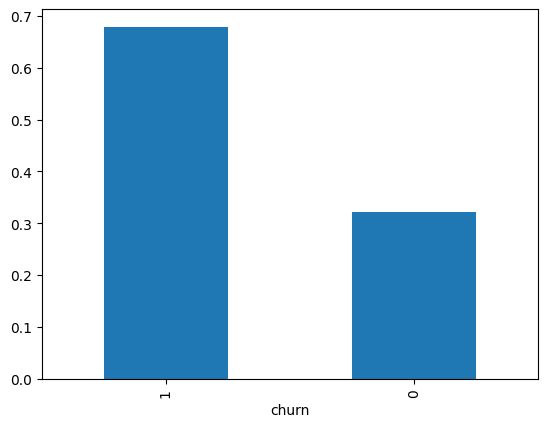

In [73]:
df1['churn'].value_counts(normalize=True).plot(kind='bar')

In [74]:
df1.head()

,Driver_ID,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,churn,Quarterly_Rating_Increased,Income_Increased
0,1,3,28.0,0.0,61722.271375,2.0,57387.0,1.0,1.0,1597316.03,2.0,1,0,0
1,2,2,31.0,0.0,66427.244663,2.0,67016.0,2.0,2.0,0.00,1.0,0,0,0
2,4,5,43.0,0.0,62173.028120,2.0,65603.0,2.0,2.0,350000.00,1.0,1,0,0
3,5,3,29.0,0.0,66851.069231,0.0,46368.0,1.0,1.0,120360.00,1.0,1,0,0
4,6,5,31.0,1.0,69408.235043,1.0,78728.0,3.0,3.0,1265000.00,2.0,0,1,0


## Standardization

In [75]:
x=np.array(df1[['MMM-YY','Age', 'Gender', 'city_encode', 'Education', 'Income', 'Joining_Designation', 'Grade', 'Total_Business_Value', 'Last_Quarterly_Rating','Quarterly_Rating_Increased','Income_Increased']])
y=np.array(df1[['churn']])

In [76]:
x_scaled=MinMaxScaler()

In [77]:
X=x_scaled.fit_transform(x)

In [78]:
X=pd.DataFrame(X)

In [79]:
X.columns=['MMM-YY','Age', 'Gender', 'city_encode', 'Education', 'Income', 'Joining_Designation', 'Grade', 'Total_Business_Value', 'Last_Quarterly_Rating','Quarterly_Rating_Increased','Income_Increased']

In [80]:
X.head()

,MMM-YY,Age,Gender,city_encode,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Income_Increased
0,0.086957,0.189189,0.0,0.310533,1.0,0.345190,0.00,0.00,0.052532,0.333333,0.0,0.0
1,0.043478,0.270270,0.0,0.610136,1.0,0.416456,0.25,0.25,0.004539,0.000000,0.0,0.0
2,0.173913,0.594595,0.0,0.339236,1.0,0.405998,0.25,0.25,0.015055,0.000000,0.0,0.0
3,0.086957,0.216216,0.0,0.637124,0.0,0.263637,0.00,0.00,0.008155,0.000000,0.0,0.0
4,0.173913,0.270270,1.0,0.799959,0.5,0.503138,0.50,0.50,0.042547,0.333333,1.0,0.0


## Data preparation for modeling

### train-test-Split

In [81]:
from sklearn.model_selection import train_test_split
X_train , X_test,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.2,
                                                      random_state=42)

In [82]:
X_train.shape

(1904, 12)

In [83]:
y_train.shape

(1904, 1)

In [84]:
X_test.shape

(477, 12)

In [85]:
y_test.shape

(477, 1)

# Model building

## Ensemble - Bagging Algorithm - Random Forest

In [86]:
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve

Train Score is : 0.8077731092436975
Test Score is : 0.8259958071278826
ROC-AUC score  test dataset:   0.81361875637105
Accuracy Score :  0.8259958071278826 

              precision    recall  f1-score   support

           0       0.85      0.55      0.66       150
           1       0.82      0.95      0.88       327

    accuracy                           0.83       477
   macro avg       0.83      0.75      0.77       477
weighted avg       0.83      0.83      0.81       477

Confusion Matrix :


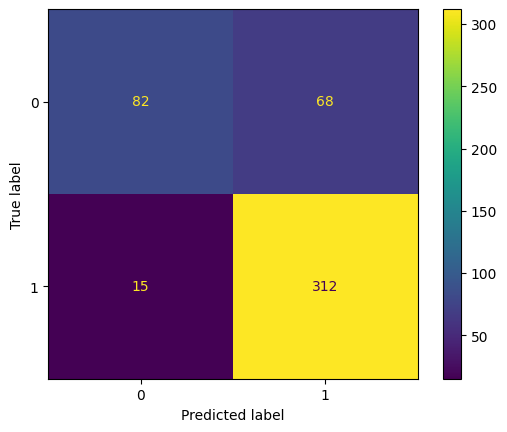

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train.reshape(-1))
y_pred=clf.predict(X_test).reshape(-1,1)
prob = clf.predict_proba(X_test)
print(f'Train Score is : {clf.score(X_train,y_train)}')
print(f'Test Score is : {clf.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# Random Forest with class weights and hyper parameter tuing

Best parameters are : {'max_depth': 6, 'n_estimators': 200}
The F1 score is : 0.8749102878721379
Train Score is : 0.8943396226415095
Test Score is : 0.8817518248175182
ROC-AUC score  test dataset:   0.8594087665647299
Accuracy Score :  0.8301886792452831 

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       150
           1       0.84      0.92      0.88       327

    accuracy                           0.83       477
   macro avg       0.82      0.78      0.79       477
weighted avg       0.83      0.83      0.82       477

Confusion Matrix :


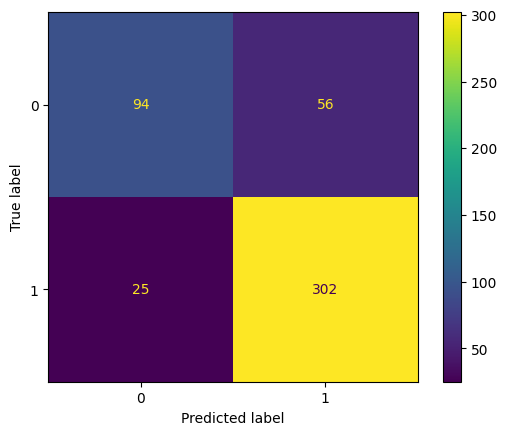

In [88]:
param = {'max_depth':[2,3,4,5,6], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train.reshape(-1))
prob = c.predict_proba(X_test)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The F1 score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test).reshape(-1)
print(f'Train Score is : {c.score(X_train,y_train)}')
print(f'Test Score is : {c.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=c.classes_)
disp.plot()
plt.show()

## ROC-AUC Curve

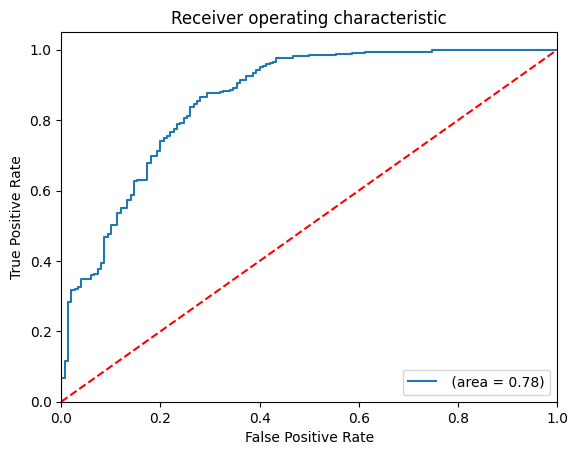

In [89]:
roc_auc = roc_auc_score(y_test, c.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=' (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

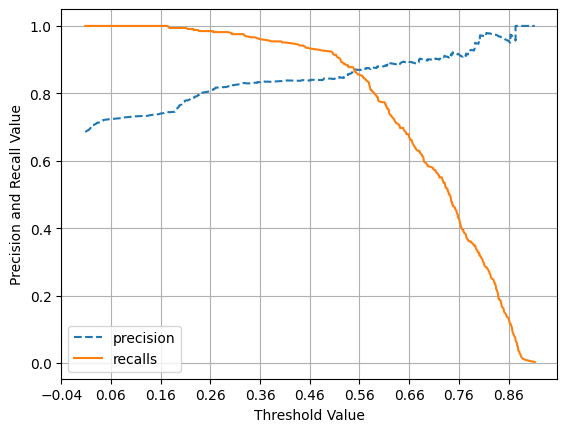

In [90]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, c.predict_proba(X_test)[:,1])

# Ensemble - Boosting Algorithm - Gradient Booting classifier

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

Train Score is : 0.8534663865546218
Test Score is : 0.8280922431865828
ROC-AUC score  test dataset:   0.8659225280326198
Accuracy Score :  0.8280922431865828 

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       150
           1       0.83      0.94      0.88       327

    accuracy                           0.83       477
   macro avg       0.83      0.76      0.78       477
weighted avg       0.83      0.83      0.82       477

Confusion Matrix :


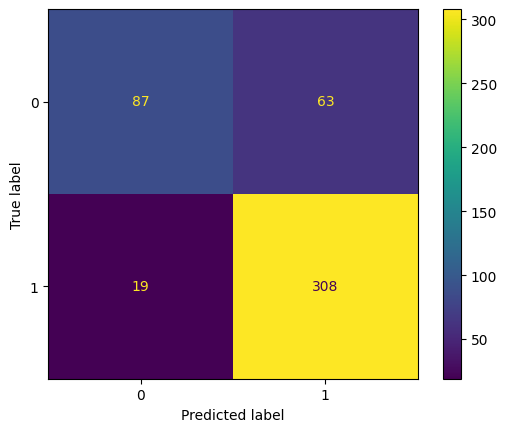

In [92]:
gbc = GradientBoostingClassifier(n_estimators=150, max_depth=2, loss = 'log_loss')
gbc.fit(X_train, y_train.reshape(-1))
y_pred = gbc.predict(X_test).reshape(-1)
print(f'Train Score is : {gbc.score(X_train,y_train)}')
print(f'Test Score is : {gbc.score(X_test,y_test)}')
prob = gbc.predict_proba(X_test)
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=gbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gbc.classes_)
disp.plot()
plt.show()

# GradientBoosting with Hyperparameter tuing

Best parameters are : {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
The score is : 0.8813322376197974
Train Score is : 0.8865300146412884
Test Score is : 0.886039886039886
ROC-AUC score  test dataset:   0.8613965341488277
Accuracy Score :  0.8322851153039832 

              precision    recall  f1-score   support

           0       0.84      0.57      0.68       150
           1       0.83      0.95      0.89       327

    accuracy                           0.83       477
   macro avg       0.84      0.76      0.78       477
weighted avg       0.83      0.83      0.82       477

Confusion Matrix :


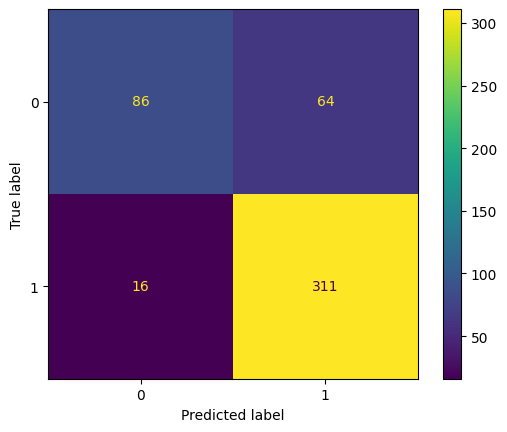

In [93]:
param = {'max_depth':[2,3,4,5,6], 'n_estimators':[100,150,200], 'learning_rate':[0.05,0.1,0.2]}

GradientBoosting = GradientBoostingClassifier()

c = GridSearchCV(GradientBoosting,param,cv=4,scoring='f1')
c.fit(X_train,y_train.reshape(-1))

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

y_pred = c.predict(X_test).reshape(-1)
prob = c.predict_proba(X_test)
print(f'Train Score is : {c.score(X_train,y_train)}')
print(f'Test Score is : {c.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=c.classes_)
disp.plot()
plt.show()

## Class Imbalance treatment

### Class Imbalance treatment with smote

In [94]:
df1['churn'].value_counts()

churn
1    1616
0     765
Name: count, dtype: int64

In [95]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())


In [96]:
## After over sampling : 
X_smote.shape, y_smote.shape

((2578, 12), (2578,))

Best parameters are : {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
The F1 score is : 0.8524977854098494
Train Score is : 1.0
Test Score is : 0.8554396423248882
ROC-AUC score  test dataset:   0.8429765545361876
Accuracy Score :  0.7966457023060797 

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       150
           1       0.83      0.88      0.86       327

    accuracy                           0.80       477
   macro avg       0.77      0.75      0.76       477
weighted avg       0.79      0.80      0.79       477

Confusion Matrix :


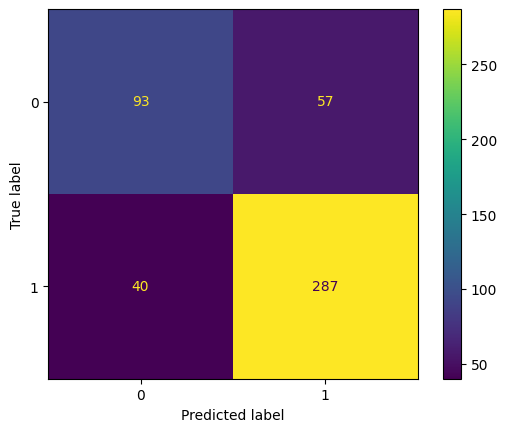

In [97]:
param = {'max_depth':[2,3,4,5,6], 'n_estimators':[100,150,200], 'learning_rate':[0.05,0.1,0.2]}

GradientBoosting = GradientBoostingClassifier()

c = GridSearchCV(GradientBoosting,param,cv=4,scoring='f1')
c.fit(X_smote,y_smote.reshape(-1))

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The F1 score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test).reshape(-1)
prob = c.predict_proba(X_test)
print(f'Train Score is : {c.score(X_train,y_train)}')
print(f'Test Score is : {c.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=c.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=c.classes_)
disp.plot()
plt.show()

### Insights:
- Using smote actually reduced the score of a model
- It better to use mode without SMOTE

# XGBoost Algorithm 

Best parameters are : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
The F1 score is : 0.8813165022921147
Train Score is : 0.9009937430990063
Test Score is : 0.8866571018651362
ROC-AUC score  test dataset:   0.8663710499490316
Accuracy Score :  0.8343815513626834 

              precision    recall  f1-score   support

           0       0.83      0.59      0.69       150
           1       0.84      0.94      0.89       327

    accuracy                           0.83       477
   macro avg       0.83      0.77      0.79       477
weighted avg       0.83      0.83      0.83       477

Confusion Matrix :


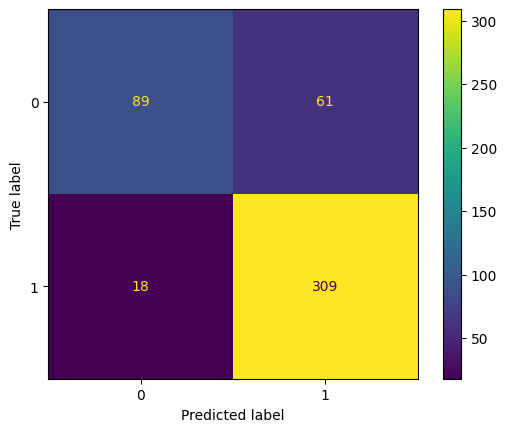

In [98]:
from xgboost import XGBClassifier

param = {'max_depth':[2,3,4,5,6], 'n_estimators':[100,150,200], 'learning_rate':[0.05,0.1,0.2]}

XGBC = XGBClassifier()

xgb = GridSearchCV(XGBC,param,cv=4,scoring='f1')
xgb.fit(X_train,y_train.reshape(-1))
   
display(xgb)
y_pred = xgb.predict(X_test).reshape(-1)
prob = xgb.predict_proba(X_test)
print(f'Train Score is : {xgb.score(X_train,y_train)}')
print(f'Test Score is : {xgb.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb.classes_)
disp.plot()
plt.show()

# XGBoost Algorithm with smote

Best parameters are : {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
The F1 score is : 0.8524051511123585
Train Score is : 0.981175566653861
Test Score is : 0.863568215892054
ROC-AUC score  test dataset:   0.8377573904179408
Accuracy Score :  0.8092243186582809 

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       150
           1       0.85      0.88      0.86       327

    accuracy                           0.81       477
   macro avg       0.78      0.77      0.77       477
weighted avg       0.81      0.81      0.81       477

Confusion Matrix :


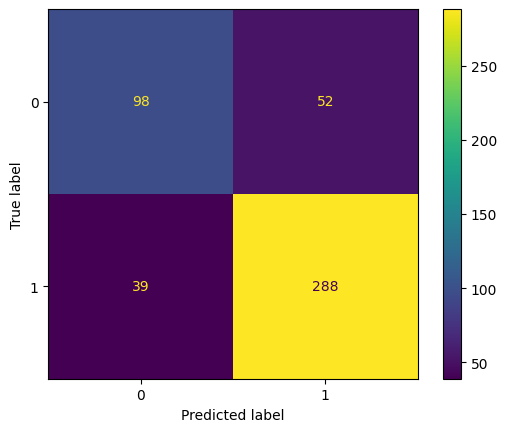

In [99]:
from xgboost import XGBClassifier

param = {'max_depth':[2,3,4,5,6], 'n_estimators':[100,150,200], 'learning_rate':[0.05,0.1,0.2]}

XGBC = XGBClassifier()

xgb = GridSearchCV(XGBC,param,cv=4,scoring='f1')
xgb.fit(X_smote,y_smote.reshape(-1))
   
display(xgb)
y_pred = xgb.predict(X_test).reshape(-1)
prob = xgb.predict_proba(X_test)
print(f'Train Score is : {xgb.score(X_train,y_train)}')
print(f'Test Score is : {xgb.score(X_test,y_test)}')
print("ROC-AUC score  test dataset:  ", roc_auc_score(y_test, prob[:, 1]))
print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))
print('Confusion Matrix :')
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb.classes_)
disp.plot()
plt.show()

# Inferences :

- From data distribution: Male 1380 Female 956
- Churn : distribution: 1 1616 (67.870%) 0 765 (32.12%)
- Probability of Churn is higher in case of education level 0 and 1 than 2.
- In case of joining destination 1, probability of churn is higher.
- In case of quarterly rating is 1, probability of churn is significantly higher.
- Also same pattern is observed in case of when driver's quarterly rating has increased through out tenure.
- Due to some reason , for drivers who joined in 2018 and 2019 , probability of churn is very high compare to 2020 and before 2018.

### Random Forest :
- Train Score is : 0.8077731092436975
- Test Score is : 0.8259958071278826
- ROC-AUC score  test dataset:   0.81361875637105
- Accuracy Score :  0.8259958071278826 

### on Grid Search CV : RF :
- Best parameters are : {'max_depth': 6, 'n_estimators': 100}
- The F1 score is : 0.8758759834014072
- Train Score is : 0.894457099468489
- Test Score is : 0.8744460856720827
- ROC-AUC score  test dataset:   0.81361875637105
- Accuracy Score :  0.8218029350104822 

### GradientBoostingClassifier: n_estimators=150, max_depth=2, loss = 'log_loss'
- Train Score is : 0.8534663865546218
- Test Score is : 0.8280922431865828
- ROC-AUC score  test dataset:   0.8659225280326198
- Accuracy Score :  0.8280922431865828 

### GradientBoostingClassifier : GradientBoosting with Hyperparameter tuing
- Best parameters are : {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
- The F1 score is : 0.8818087174605473
- Train Score is : 0.9125277983691623
- Test Score is : 0.8888888888888888
- ROC-AUC score  test dataset:   0.8583282364933741
- Accuracy Score :  0.8385744234800838 

### GradientBoostingClassifier : GradientBoosting with Hyperparameter tuing and Class Imbalance treatment with smote
- Best parameters are : {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}
- The F1 score is : 0.8540528361136509
- Train Score is : 0.9965210668728257
- Test Score is : 0.8618618618618619
- ROC-AUC score  test dataset:   0.8458103975535168
- Accuracy Score :  0.8071278825995807 

### XGBoost Classifier: 
- Best parameters are : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- The F1 score is : 0.8813165022921147
- Train Score is : 0.9009937430990063
- Test Score is : 0.8866571018651362
- ROC-AUC score  test dataset:   0.8663710499490316
- Accuracy Score :  0.8343815513626834

### XGBoost Classifier: With smoteClass Imbalance treatment with smote
- Best parameters are : {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
- The F1 score is : 0.8524051511123585
- Train Score is : 0.981175566653861
- Test Score is : 0.863568215892054
- ROC-AUC score  test dataset:   0.8377573904179408
- Accuracy Score :  0.8092243186582809 